# Simple 2 Moving Average Model

In [1]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
from sharpe import gen_sharpe
from ma_cross_obj import MovingAverageTable

Downloading Data:

In [2]:
# YYYY-MM-DD
# for current day: str(date.today() - timedelta(1))
end = str(date.today() - timedelta(1))
# for 60 days ago for smaller timeframes: str(date.today() - timedelta(59))
# for 730 days ago for smaller timeframes: str(date.today() - timedelta(729))
start = str(date.today() - timedelta(729))

# model trading days input for crossover visualization in days. standard 1Y is 252 days. Can use multiples of 252 to track years
model_days = 3223

#multi_level_index = False | removes ticker noise in table
QQQ = (yf.download("QQQ", start, end, interval = "1h", multi_level_index = False))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Complete Table Creation

In [3]:
QQQ_ma_table = MovingAverageTable(QQQ, ma1 = 50, ma2 = 250)
QQQ_ma_table.gen_table()

,Day Count,Open,High,Low,Close,50-day MA,250-day MA,Return,Cumulative Return,MA Model Return,Cumulative MA Model Return,Signal,Entry
Datetime,,,,,,,,,,,,,
2023-06-22 18:30:00+00:00,251,364.830,365.690,364.360,364.92,365.288,342.402,NaN,NaN,0.022,0.022,1,1.0
2023-06-22 19:30:00+00:00,252,364.925,366.330,364.635,366.23,365.423,342.583,0.358,0.359,0.358,0.381,1,0.0
2023-06-23 13:30:00+00:00,253,362.210,363.300,360.823,362.30,365.552,342.776,-1.079,-0.718,-1.079,-0.697,1,0.0
2023-06-23 14:30:00+00:00,254,362.280,363.200,361.350,361.62,365.587,342.950,-0.188,-0.904,-0.188,-0.883,1,0.0
2023-06-23 15:30:00+00:00,255,361.620,363.870,361.350,363.84,365.604,343.119,0.612,-0.296,0.612,-0.275,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28 15:30:00+00:00,3469,467.454,469.140,466.206,466.55,451.829,463.936,-0.192,27.850,0.192,-4.443,-1,0.0
2025-04-28 16:30:00+00:00,3470,466.620,468.380,466.030,466.37,452.120,463.855,-0.039,27.801,0.039,-4.406,-1,0.0
2025-04-28 17:30:00+00:00,3471,466.380,469.890,466.150,469.61,452.464,463.766,0.692,28.688,-0.692,-5.065,-1,0.0


# MA Cross-Over Grid Visualization

from 2023-06-22-18:30 to 2025-04-28-19:30
count of buy signals: 4.0
count of sell signals: 4.5


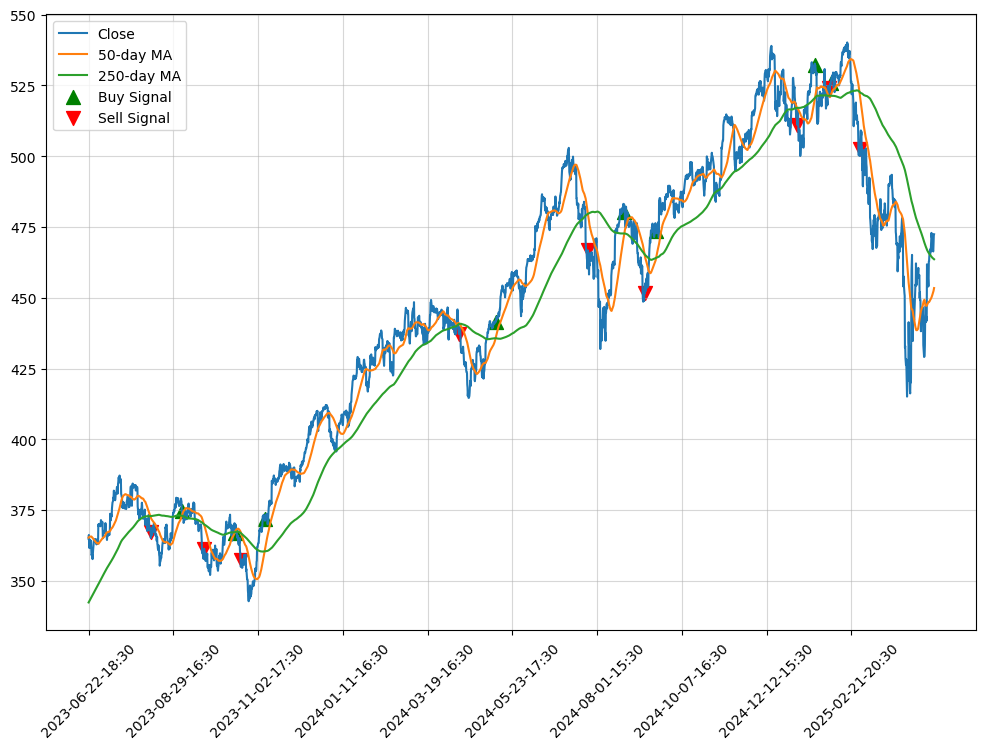

In [4]:
QQQ_ma_table.gen_ma_cross_visual(model_days)

# Buy/Hold to SMA Returns Comparison

QQQ Cumulative Buy/Hold Return: 29.47
QQQ Cumulative MA Model Return: -5.64
 from 2023-06-22-18:30 to 2025-04-28-19:30


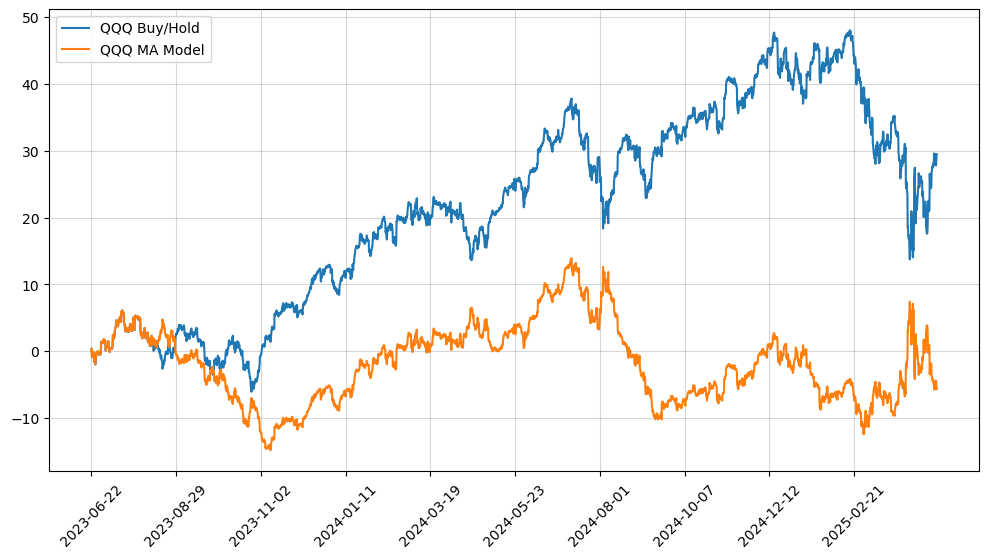

In [5]:
QQQ_ma_table.print_cumulative_return("QQQ")
QQQ_ma_table.gen_buyhold_comp("QQQ")

# Sharpe Ratio:

In [6]:
print('Buy/Hold Sharpe Ratio:', round(gen_sharpe(QQQ_ma_table.gen_table()['Return']), 2))
print('Model Sharpe Ratio:', round(gen_sharpe(QQQ_ma_table.gen_table()['MA Model Return']), 2))

Buy/Hold Sharpe Ratio: 0.27
Model Sharpe Ratio: -0.02
